### Challenge: Iterate and evaluate your classifier

*It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:*

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

*Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.*

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import string
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import nltk
#nltk.download('stopwords')  # required the first time 
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Load data and rename columns 

data = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
data.columns = ['review', 'pos']

In [3]:
data.head()

,review,pos
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


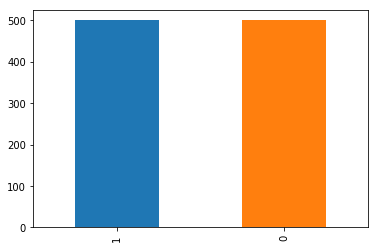

In [4]:
# Equal number of spam and ham, which shows that we don't have class imbalance
data.pos.value_counts().plot(kind='bar')

In [5]:
# For visual inspection of common words in the reviews. 

#list(data[data.pos == 1].review)  #all complete pos feedback #list shows full content
#listb(data[data.pos == 0].review)

In [11]:
# Or, yet better - use tokenizer to divide sentences into words, remove stopwords and punctuations

words = " ".join(data.review) #joined dataframe to create string to pass on to the word_tokenize

stop = set(stopwords.words('english'))
word_tokens = word_tokenize(words)  #split text into tokens 

tokenized_words = []
for word in word_tokens:
    if word.lower() not in stop and word.lower() not in string.punctuation:
        tokenized_words.append(word)
        
tokenized_count = Counter(tokenized_words).most_common()
#tokenized_count[:50]
#words

### Classifier version: 1 - without sklearn modules 

In [13]:
# Feature Engineering 
# Features one: adding words frequent adjectives from reviews 

pos_keywords = ['good', 'best', 'excellent', 'fine', 'nice', 'great',
               'satisfied', 'fulfill', 'love', 'easy', 'happy', 
               'recommend', 'impressed', 'incredible', 'well', 'awesome', 'cool',
               'fantastic', 'sturdy' ]

# ':-)' in the keywords created an error

for key in pos_keywords:
    data[str(key)] = data.review.str.contains(' '+ str(key), case=False)

In [14]:
#Features two: Adding intensifiers 

pos_intensifiers = ['very', 'pretty', 'highly', 'really', 'perfectly']

for key in pos_intensifiers: 
    data[str(key)] = data.review.str.contains(' ' + str(key) + ' ', case=False)

In [15]:
data.head()

,review,pos,good,best,excellent,fine,nice,great,satisfied,fulfill,...,well,awesome,cool,fantastic,sturdy,very,pretty,highly,really,perfectly
0,So there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


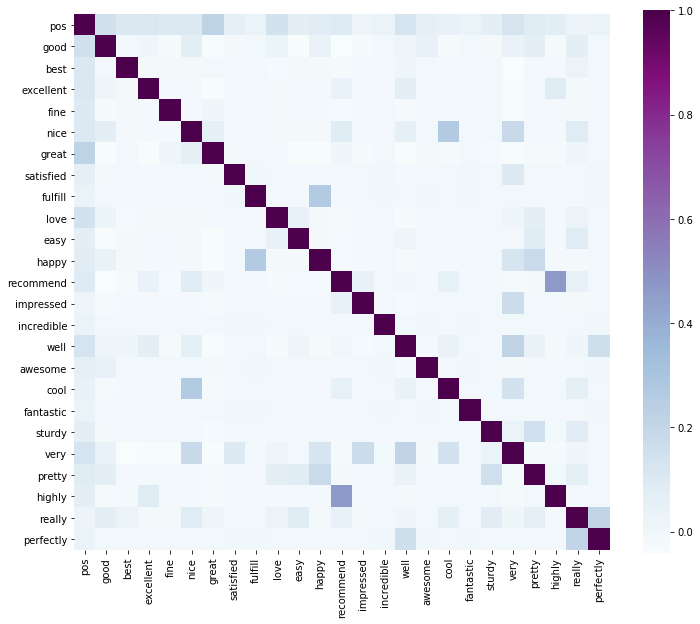

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='BuPu', square=True)

In [17]:
# Training data 

X = data[pos_keywords + pos_intensifiers]  # this looks like a sparse matrix, mostly zero and some 1s.
y = data.pos

In [18]:
# Binary data - Bernoulli

from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB() # instantiate

# fit model 
bnb.fit(X, y)  #learning which features correspond to a pos senting 

y_pred = bnb.predict(X)  #.predict in classifier, and .transform in feature selection 

In [19]:
# Cross validation scores 

scores = cross_val_score(bnb, X, y, cv=10)
print("Mean 10-fold cross-validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y, y_pred))

Mean 10-fold cross-validated accuracy: 0.70 (+/- 0.10)
The confusion matrix is as follows: 
 [[438  62]
 [231 269]]


In [20]:
# Finding feature values and their indices 

bnb.coef_  #values

array([[-2.30657711, -3.32822836, -3.57954279, -3.65365076, -3.51054992,
        -2.09146573, -4.60916221, -5.52545294, -3.22286785, -3.65365076,
        -3.65365076, -3.12755767, -4.42684065, -5.52545294, -2.72209256,
        -4.60916221, -4.27268997, -5.52545294, -4.42684065, -2.19324843,
        -4.02137554, -4.13915858, -3.57954279, -5.52545294]])

In [21]:
bnb_idx = np.argsort(bnb.coef_)[0][::-1]  #accessing list within array and reversing it.
# [0][::-1] because argsort sorts indexes for its ascending values
bnb_idx

array([ 5, 19,  0, 14, 11,  8,  1,  4,  2, 22,  9,  3, 10, 20, 21, 16, 18,
       12,  6, 15,  7, 17, 13, 23])

In [22]:
#np.argsort(bnb.coef_)  #returns sorted indexes of values in ascending order

In [23]:
print("The important features are: {}".format(X.columns[bnb_idx]))

The important features are: Index(['great', 'very', 'good', 'well', 'recommend', 'love', 'best', 'nice',
       'excellent', 'really', 'easy', 'fine', 'happy', 'pretty', 'highly',
       'cool', 'sturdy', 'impressed', 'satisfied', 'awesome', 'fulfill',
       'fantastic', 'incredible', 'perfectly'],
      dtype='object')


In [24]:
print("Number of mislabeled points out of total {} points: {}".format(
X.shape[0], (y != y_pred).sum()))  #FP + FN

Number of mislabeled points out of total 1000 points: 293


In [25]:
## Manually calculating Confusion Matrix
#
## Transforming nparray to a Series for adding to a dataframe 
#y_pred_series = pd.Series(y_pred)
#
## Creating a dataframe with only y and y_pred for manually calculating confusion matrix 
#y_df = pd.concat([y, y_pred_series], axis=1)   ####
#y_df.columns = ['y', 'y_pred']

#print("TP: {} \nFP: {} \nTN: {} \nFN: {}".format(y_df.groupby('y').y_pred.value_counts()[0][0], 
#y_df.groupby('y').y_pred.value_counts()[1][0],
#y_df.groupby('y').y_pred.value_counts()[0][1],
#y_df.groupby('y').y_pred.value_counts()[1][1]))

# try .apply for manually calculating the confusion matrix
#y_df.apply(lambda x: 0 if x["y"] == x["y_pred"] else 1, axis = 1).sum()

In [26]:
# Manual CV

#def CV(df_x, df_y, k):
#    
#    CV_matrix = []
#    from sklearn.model_selection import train_test_split
#    for fold in np.arange(10):
#        X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=k, random_state=None)
#    
#        from sklearn.naive_bayes import BernoulliNB
#        bnb = BernoulliNB()
#        bnb.fit(X_train, y_train)
#
#    # Classify, storing the result in a new variable 
#        y_pred = bnb.predict(X_test)
#        CV_matrix.append(((y_test == y_pred).sum() / len(y_pred)*100))
#    print("Cross-validation scores: " + str((CV_matrix)))
#    print("Mean of cross validation scores {}".format(round(np.mean(CV_matrix)),2))

### CV(X, y, .33)

In [27]:
#list_alpha = np.arange(1/100000, 20, 0.11)
#np.zeros(len(list_alpha))

### Classifier version 2: Using CountVectorizer with Bernoulli NB with alpha 



In [28]:
# Turn off pretty printing of jupyter notebook which generates long lines
#%pprint   # ON and OFF alternatively 

#reviews2 = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
#reviews2.columns = ['review', 'pos']
#rev_string = [" ".join(clf2['review'])]  # [] list otherwise CountVectorizer throws Valueerror 

In [29]:
#len(reviews2.review)
#type(data_train)
#CountVectorizer.fit_transform?

In [30]:
# Import countvectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer and create sparse matrix 
data_vec = CountVectorizer(stop_words='english')
X = data_vec.fit_transform(data.review)   # review string turned into sparse vectors by word frequency counts 
X.shape   #1000, 1642

(1000, 1642)

In [71]:
# Train test split (80-20) to train and test the classifiers

X_train, X_test, y_train, y_test = train_test_split(
    X, data.pos, test_size = .2)

# Each of these variables is a Series.

print([np.shape(X_train), np.shape(X_test)], ytf_train.shape, ytf_test.shape)

[(800, 1642), (200, 1642)] (800,) (200,)


In [62]:
# Bernoulli Naive Bayes with alpha

from sklearn import metrics

list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
CV = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    CV[count] = (cross_val_score(bayes, X_train, y_train, cv=10)).mean()
    count = count + 1 

In [63]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, CV])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Mean Cross-validation'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Mean Cross-validation
0,0.00001,0.98125,0.790,0.814433,0.766990,0.760978
1,0.11001,0.97875,0.790,0.824742,0.761905,0.779761
2,0.22001,0.97625,0.805,0.855670,0.768519,0.779746
3,0.33001,0.97375,0.805,0.855670,0.768519,0.778465
4,0.44001,0.97375,0.805,0.855670,0.768519,0.778496
5,0.55001,0.97375,0.800,0.855670,0.761468,0.784731
6,0.66001,0.97250,0.800,0.855670,0.761468,0.784747
7,0.77001,0.97125,0.810,0.865979,0.770642,0.784747
8,0.88001,0.97000,0.810,0.865979,0.770642,0.784747
9,0.99001,0.97000,0.805,0.855670,0.768519,0.783528


In [64]:
scores = cross_val_score(bayes, X_train, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means


Mean 10-fold cross-validated accuracy from Bernoulli NB: 0.52 (+/- 0.03)


In [65]:
CV.mean()

0.6506585152814056

## Chris: In the above two cells, why are the CV scores different? 

## Classifier version 3: Bernoulli NB with tfidfVectorizer

In [76]:
# First, transforming data_vec (matrix with raw frequency counts) to tfidf matrix

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

X_tfidf.shape

(1000, 1642)

In [77]:
# Splitting train and test subsets on X_tfidf 

Xtf_train, Xtf_test, ytf_train, ytf_test = train_test_split(
    X_tfidf, data.pos, test_size = .2)

print(Xtf_train.shape, Xtf_test.shape, ytf_train.shape, ytf_test.shape)

(800, 1642) (200, 1642) (800,) (200,)


## Chris: is it still okay to have data.pos in this function? hasn't the indices changed? 

In [78]:
## Running Bernoulli Naive Bayes with tfidf features 

list_alpha = np.arange(1/1e5, 20, .11)
train_score = np.zeros(len(list_alpha))
test_score = np.zeros(len(list_alpha))
test_precision = np.zeros(len(list_alpha))
test_recall = np.zeros(len(list_alpha))
CV_score = np.zeros(len(list_alpha))

count = 0 
for alpha in list_alpha:
    bnb = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bnb.fit(Xtf_train, ytf_train)
    train_score[count] = bnb.score(Xtf_train, ytf_train)
    test_score[count] = bnb.score(Xtf_test, ytf_test)
    test_precision[count] = metrics.precision_score(ytf_test, bnb.predict(Xtf_test))
    test_recall[count] = metrics.recall_score(ytf_test, bnb.predict(Xtf_test))
    CV_score[count] = (cross_val_score(bnb, Xtf_train, ytf_train, cv=10)).mean()
    count+= 1


In [79]:
matrix = np.matrix(np.c_[list_alpha, train_score, test_score, test_precision, test_recall, CV_score])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Mean Cross-validation'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Mean Cross-validation
0,0.00001,0.97375,0.780,0.785047,0.800000,0.759837
1,0.11001,0.97000,0.805,0.800000,0.838095,0.772308
2,0.22001,0.96875,0.815,0.803571,0.857143,0.783544
3,0.33001,0.96875,0.815,0.803571,0.857143,0.779841
4,0.44001,0.96625,0.805,0.794643,0.847619,0.779841
5,0.55001,0.96125,0.810,0.801802,0.847619,0.779872
6,0.66001,0.95750,0.805,0.800000,0.838095,0.778637
7,0.77001,0.95625,0.800,0.798165,0.828571,0.781138
8,0.88001,0.95500,0.800,0.798165,0.828571,0.779872
9,0.99001,0.95375,0.800,0.798165,0.828571,0.783607


In [80]:
CV_score.mean()

0.6948523893671574

In [81]:
scores = cross_val_score(bnb, Xtf_train, ytf_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means


Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: 0.56 (+/- 0.07)


## To discuss on Thursday - 
- points that have Chris's name on it. And in general what the codes/models are doing and if that's suggested etc. 

In [52]:
BernoulliNB?

In [37]:


from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB() # instantiate

# fit model 
bnb.fit(data_train_count, y_train) #learning which features correspond to a pos senting 

y_pred = bnb.predict(data_train_count)

scores = cross_val_score(bnb, data_train_count, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))

Mean 10-fold cross-validated accuracy from Bernoulli NB: 0.81 (+/- 0.07)
The confusion matrix is as follows: 
 [[387  23]
 [  8 382]]


In [41]:
# Bernoulli NB with TF-IDF sparse matrix

bnb1 = BernoulliNB() 
bnb1.fit(data_train_tfidf, y_train)

y_pred = bnb.predict(data_train_tfidf)

scores = cross_val_score(bnb1, data_train_tfidf, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB and tfidf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))


Mean 10-fold cross-validated accuracy from Bernoulli NB and tfidf: 0.81 (+/- 0.07)
The confusion matrix is as follows: 
 [[387  23]
 [  8 382]]


In [138]:
## Running Multinomial 

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(data_train_count, y_train)
y_pred = mnb.predict(data_train_count) 

scores = cross_val_score(mnb, data_train_count, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Multinomial: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))


Mean 10-fold cross-validated accuracy from Multinomial: 0.81 (+/- 0.07)
The confusion matrix is as follows: 
 [[372  17]
 [  8 403]]


In [139]:
## Running Multinomial on tfidf

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(data_train_tfidf, y_train)
y_pred = mnb.predict(data_train_tfidf) 

scores = cross_val_score(mnb, data_train_tfidf, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Multinomial: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))


Mean 10-fold cross-validated accuracy from Multinomial: 0.80 (+/- 0.06)
The confusion matrix is as follows: 
 [[374  15]
 [  8 403]]


In [106]:
# review string turned into sparse vectors by word frequency counts 
#rev2_counts = data_train_vec.fit_transform(reviews2.review)
#rev2_counts.shape

### Classifier version 3: TF-IDF with word tokenizer

In [143]:
#CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, 
#lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', 
#ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False)

# Import countvectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer and create empty vector 
data_train_vec = CountVectorizer(tokenizer=word_tokenize)

# review string turned into sparse vectors by word frequency counts 
data_train_count = data_train_vec.fit_transform(data_train)
# data_train_fitted.shape

# Using tfidf transformer to transform raw frequency counts to tfidf features 
tfidf_transformer = TfidfTransformer()
data_train_tfidf = tfidf_transformer.fit_transform(data_train_count)

#rev3_vec = CountVectorizer(tokenizer=nltk.word_tokenize)
#
#rev3_counts = rev3_vec.fit_transform(reviews2.review)
#rev3_counts.shape  #1000, 1934, was 1847 with default

In [147]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(data_train_tfidf, y_train)
y_pred = bnb.predict(data_train_tfidf)

scores = cross_val_score(bnb, data_train_tfidf, y_train)
print("Mean CV score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2)) #.76, 0.02%

print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))

Mean CV score: 0.76 (+/- 0.02)
The confusion matrix is as follows: 
 [[355  34]
 [ 10 401]]


In [150]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB() # instantiate

#MultinomialNB().fit(clf2_train, y2_train)
bnb.fit(data_train_tfidf, y_train)

y_pred = bnb.predict(data_train_tfidf)

scores = cross_val_score(bnb, data_train_tfidf, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB and tfidf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))  #.78%, 0.05

Mean 10-fold cross-validated accuracy from Bernoulli NB and tfidf: 0.78 (+/- 0.05)
The confusion matrix is as follows: 
 [[355  34]
 [ 10 401]]


In [152]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(data_train_tfidf, y_train)
y_pred = mnb.predict(data_train_tfidf) 

scores = cross_val_score(mnb, data_train_tfidf, y_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Multinomial: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))  #means
# .80, 0.07

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y_train, y_pred))


Mean 10-fold cross-validated accuracy from Multinomial: 0.80 (+/- 0.07)
The confusion matrix is as follows: 
 [[371  18]
 [ 13 398]]


In [120]:
rev3_vec.get_feature_names()

['!',
 '#',
 '$',
 '%',
 '&',
 "''",
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '(',
 ')',
 '*',
 ',',
 '-',
 '--',
 '-good',
 '.',
 '.-',
 '..',
 '...',
 '.i',
 '.pretty',
 '.very',
 '/',
 '1',
 '1.',
 '1.2',
 '1.3',
 '1/2',
 '10',
 '100',
 '11',
 '12',
 '13',
 '15',
 '18',
 '2',
 '2-3',
 '20',
 '2000',
 '2005',
 '2160',
 '24',
 '2mp',
 '3',
 '325',
 '350',
 '375',
 '3o',
 '4.2',
 '45',
 '4s',
 '5',
 '5+',
 '5-year',
 '50',
 '5020',
 '510',
 '5320',
 '6',
 '680',
 '7',
 '7.44',
 '700w',
 '8',
 '8125',
 '8525',
 '8530',
 ':',
 ';',
 '?',
 '[',
 ']',
 '``',
 'a',
 'abhor',
 'ability',
 'able',
 'abound',
 'about',
 'above',
 'absolutel',
 'absolutely',
 'ac',
 'accept',
 'acceptable',
 'access',
 'accessable',
 'accessing',
 'accessory',
 'accessoryone',
 'accidentally',
 'accompanied',
 'according',
 'activate',
 'activated',
 'activesync',
 'actually',
 'ad',
 'adapter',
 'adapters',
 'add',
 'addition',
 'additional',
 'address',
 'adhesive',
 'adorable',
 'advertised',
 'advise',

In [98]:
# transforming to tf-idf

rev3_vec = CountVectorizer(tokenizer=nltk.word_tokenize)

rev3_counts = rev3_vec.fit_transform(reviews2.review)
rev3_tfidf = tfidf_transformer.fit_transform(rev3_counts)



In [99]:
# train test split 

rev3_vec = CountVectorizer(tokenizer=nltk.word_tokenize)

rev3_counts = rev3_vec.fit_transform(reviews2.review)
rev3_tfidf = tfidf_transformer.fit_transform(rev3_counts)

clf3_train, clf3_test, y3_train, y3_test = train_test_split(rev3_tfidf, reviews2.pos, 
                                                            test_size = .2)

In [100]:
rev3_vec = CountVectorizer(tokenizer=nltk.word_tokenize)

rev3_counts = rev3_vec.fit_transform(reviews2.review)
rev3_tfidf = tfidf_transformer.fit_transform(rev3_counts)

clf3_train, clf3_test, y3_train, y3_test = train_test_split(rev3_tfidf, reviews2.pos, 
                                                            test_size = .2)
clf3 = MultinomialNB().fit(clf3_train, y3_train)

y3_pred = clf3.predict(clf3_test)

In [101]:
print(sklearn.metrics.accuracy_score(y3_test, y3_pred))
confusion_matrix(y3_test, y3_pred)

0.805


array([[73, 22],
       [17, 88]])

### Classifier version 4: TF-IDF with word tokenizer, stop words

In [105]:
stop = set(stopwords.words('english'))
rev4_vec = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=stop)

In [108]:
rev4_counts = rev4_vec.fit_transform(reviews2.review)
rev4_counts.shape  # 1827

rev4_tfidf = tfidf_transformer.fit_transform(rev4_counts)

In [109]:
# train test split 

clf4_train, clf4_test, y4_train, y4_test = train_test_split(rev4_tfidf, reviews2.pos, 
                                                            test_size = .2)

In [110]:
clf4 = MultinomialNB().fit(clf4_train, y4_train)

y4_pred = clf4.predict(clf4_test)

In [111]:
print(sklearn.metrics.accuracy_score(y4_test, y4_pred))
confusion_matrix(y4_test, y4_pred)

0.805


array([[72, 21],
       [18, 89]])

In [123]:
CountVectorizer?

In [135]:
MultinomialNB?

In [131]:
rev3_vec = CountVectorizer(tokenizer=nltk.word_tokenize)

rev3_counts = rev3_vec.fit_transform(reviews2.review)
rev3_tfidf = tfidf_transformer.fit_transform(rev3_counts)

clf3_train, clf3_test, y3_train, y3_test = train_test_split(rev3_tfidf, reviews2.pos, 
                                                            test_size = .2)
clf3 = MultinomialNB().fit(clf3_train, y3_train)

y3_pred = clf3.predict(clf3_test)

In [132]:
print(sklearn.metrics.accuracy_score(y3_test, y3_pred))
confusion_matrix(y3_test, y3_pred)

0.825


array([[77, 25],
       [10, 88]])

In [134]:
tfidf_transformer?